In [60]:
# importa a biblioteca pandas
import pandas as pd
# importa a biblioteca numpy
import numpy as np
# importa o módulo pyplot, do matplotlib
from matplotlib import pyplot as plt

# configura o matplotlib para renderizar os plots no jupyter
%matplotlib inline

# configura a formatação de inteiros, adicionando um separador de milhares
class _IntArrayFormatter(pd.formats.format.GenericArrayFormatter):

    def _format_strings(self):
        formatter = self.formatter or (lambda x: '{:,}'.format(x).replace(',', '.'))
        fmt_values = [formatter(x) for x in self.values]
        return fmt_values

pd.formats.format.IntArrayFormatter = _IntArrayFormatter

# função que formata float adicionando separador de milhares '.' e separador de decimal
#   ','
# para detalhes dos replaces, ver: 
# https://www.python.org/dev/peps/pep-0378/#main-proposal-from-nick-coghlan-originally-called-proposal-i
def format_float(f):
    
    return "{:,.2f}".format(f).replace(",", "X").replace(".", ",").replace("X", ".")

# configura a formatação de decimais, adicionando um separador de milhares
pd.set_option("display.float_format", format_float)

# Pagamentos a pessoas físicas da FCPC

Base de dados de pagamentos a pessoas físicas da Fundação Cearense de Pesquisa e Cultura.

O dataset a ser utilizado foi é a consolidação dos dados disponibilizados no [site da FCPC](http://www.fcpc.ufc.br/AcessoInformacao/PagamentoPessoaFisica), de 2010 a 19/02/2017.

* **Colunas**
  * **cpf**: CPF mascarado
  * **nome**
  * **tipo_pagamento**
  * **projeto**
  * **data**
  * **valor**
  * **filename**: nome do arquivo de origem do arquivo ([repositório com arquivos brutos](https://github.com/abevieiramota/analysis-ufc/tree/master/data/raw/fcpc/pagamento%20pessoa%20fisica))

## Leitura

In [28]:
# leitura de arquivo .CSV
#   parse_dates e date_parser especificam que a coluna data deve ser parseada como date, com o date_parser informado
fcpc = pd.read_csv("data/pagamentos_fisica_fcpc.csv", parse_dates=['data'],
                   date_parser=lambda d: pd.datetime.strptime(d, "%Y-%m-%d"))

# retorna os 3 primeiros registros
fcpc.head(2)

,cpf,nome,tipo_pagamento,projeto,data,valor,filename
0,***.000.103-**,REGILDA RODRIGUES DE SOUSA,ADIANTAMENTO PARA VIAGENS,2213 - CT - UFC/FCPC - PROJETO PROJOVEM CAMPO,2010-11-22,"240,00",2010.csv
1,***.000.103-**,REGILDA RODRIGUES DE SOUSA,ADIANTAMENTO PARA VIAGENS,2213 - CT - UFC/FCPC - PROJETO PROJOVEM CAMPO,2010-10-15,"180,00",2010.csv


In [29]:
# quantidade de registros
print("Há {} registros".format(len(fcpc)))

Há 126680 registros


## Informações gerais sobre as colunas

In [30]:
# informações estatísticas sobre os campos numéricos
fcpc.describe().T

,count,mean,std,min,25%,50%,75%,max
valor,"126.680,00","1.660,48","3.492,49","0,00","177,00","400,00","2.143,22","328.428,65"


In [31]:
# informações estatísticas sobre os campos não quantitativos
fcpc.describe(include = ['O'])

,cpf,nome,tipo_pagamento,projeto,filename
count,126680,126680,126680,126679,126680
unique,16215,17623,12,916,8
top,***.501.533-**,FRANCISCO RODRIGO PORTO CAVALCANTI,ADIANTAMENTO PARA VIAGENS,2924 - CT - UFC/FCPC - IMPLANTACAO E OFERTA DO...,2014.csv
freq,259,259,43521,13068,22143


In [32]:
# informações estatísticas sobre os campos datetime
fcpc.describe(include = ['datetime']).T

,count,unique,top,freq,first,last
data,126680,1774,2015-04-20 00:00:00,699,2010-01-04 00:00:00,2017-02-10 00:00:00


## Informações sobre os dados

#### tipos de pagamentos mais frequentes

In [42]:
# conta quantas ocorrências há para cada valor único em tipo_pagamento,
#   retornando os 3 valores com maior quantidade
fcpc.tipo_pagamento.value_counts().nlargest(3)

ADIANTAMENTO PARA VIAGENS   43.521
SERVIÇO PRESTADO - RPA      33.432
FOLHA DE PAGAMENTO - CLT    25.676
Name: tipo_pagamento, dtype: int64

#### maiores pagamentos

In [45]:
# seleciona os 3 registros com maiores valores para a coluna valor
fcpc.nlargest(3, "valor")

,cpf,nome,tipo_pagamento,projeto,data,valor,filename
122.957,***.839.713-**,FRANCISCO EDUARDO ARAUJO SOARES,SERVIÇO PRESTADO - RPA,3098 - CT - FCPC/IPLANFOR - PLANO ESTRATÉGICO ...,2016-12-19,"328.428,65",2016.csv
118.657,***.468.963-**,FRANCISCO SULIANO MESQUITA DE PAULA,SERVIÇO PRESTADO - RPA,3098 - CT - FCPC/IPLANFOR - PLANO ESTRATÉGICO ...,2016-12-19,"212.758,81",2016.csv
124.319,***.966.093-**,FAUSTO NILO COSTA JUNIOR,SERVIÇO PRESTADO - RPA,3098 - CT - FCPC/IPLANFOR - PLANO ESTRATÉGICO ...,2016-12-19,"212.391,25",2016.csv


#### pessoas que receberam maior soma

In [44]:
# agrupa os registros por nome e retorna os 3 nomes com maior soma de valor
fcpc.groupby('nome').valor.sum().nlargest(3)

nome
FRANCISCO EDUARDO ARAUJO SOARES   1.009.837,94
LEONILDO ADAO CHRISTOFOLETTI        983.093,17
JAVAM DE CASTRO MACHADO             802.283,12
Name: valor, dtype: float64

#### projetos que realizaram maior soma de despesas

In [46]:
# agrupa os registros por projeto e retorna os 5 projetos com mair soma de valor
largest_projetos = fcpc.groupby('projeto').valor.sum().nlargest(5) # maior soma de pagamentos
largest_projetos

projeto
0101 - FCPC                                                                           11.295.825,98
3098 - CT - FCPC/IPLANFOR - PLANO ESTRATÉGICO FORTALEZA 2040                           7.373.401,34
1089 - RESCISAO CONTRATUAL                                                             6.617.825,17
2924 - CT - UFC/FCPC - IMPLANTACAO E OFERTA DOS CURSOS DE GRADUACAO DA UAB/UFC 2012    6.264.561,69
2922 - CT - PETROBRAS - PROJETO AMBES                                                  5.753.658,23
Name: valor, dtype: float64

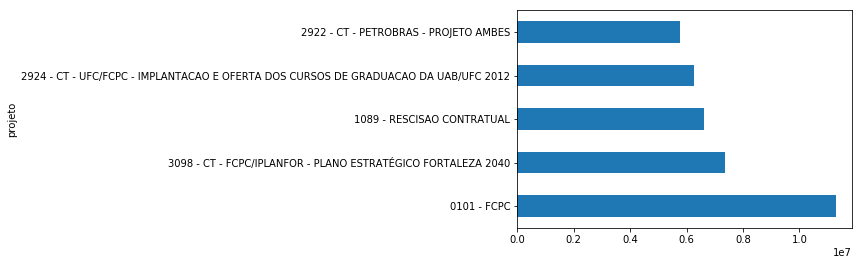

In [50]:
# plot do tipo barra horizontal dos 5 projetos com maior soma de valor
largest_projetos.plot(kind='barh')

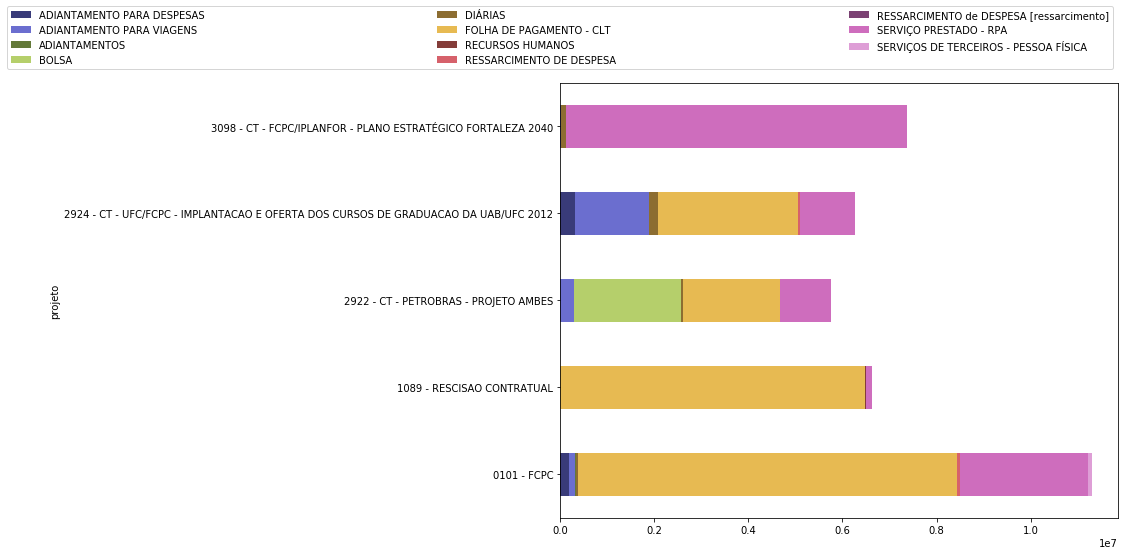

In [58]:
# para os registros dos 5 projetos com maior soma de valor
#   agrupa por projeto e tipo_pagamento e calcula a soma de valor
#   plot do tipo barra horizontal, stacked
fcpc[fcpc.projeto.isin(largest_projetos.index)].groupby(['projeto', 'tipo_pagamento']).valor.sum().unstack()\
.plot(kind = 'barh', stacked = True, figsize = (10, 8), cmap=plt.cm.Vega20b) 
# cmap alterado porque o cmap default comporta apenas 10 cores

# altera o posicionamento e formatação da legenda
plt.legend(bbox_to_anchor = (-1., 1.02, 2., .102), ncol = 3, mode = "expand", loc = 3)

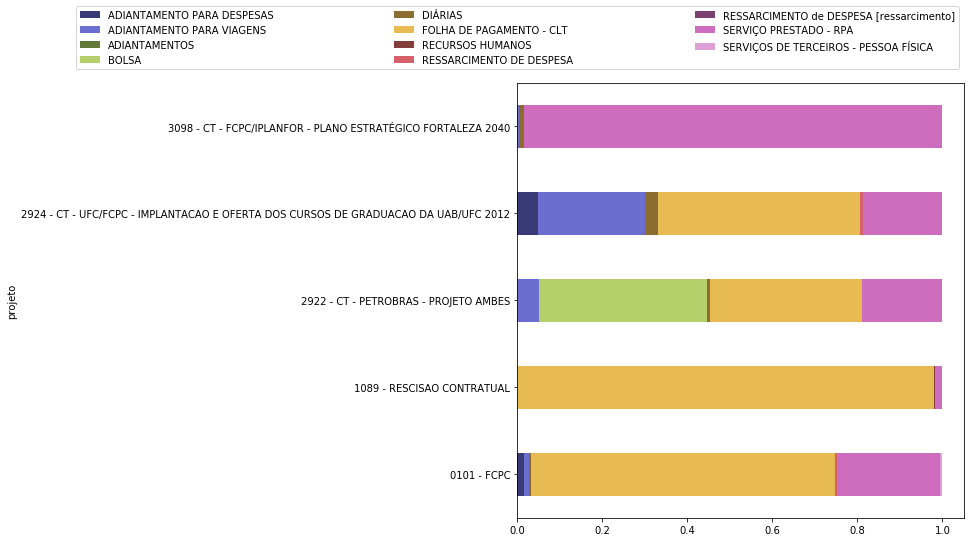

In [59]:
# mesmo plot anterior, a menos que apresenta os dados normalizados
count_subset = fcpc[fcpc.projeto.isin(largest_projetos.index)].groupby(['projeto', 'tipo_pagamento']).valor.sum().unstack()
normed_subset = count_subset.div(count_subset.sum(axis = 1), axis = 0)

normed_subset.plot(kind = 'barh', stacked = True, figsize = (8, 8), cmap=plt.cm.Vega20b)

plt.legend(bbox_to_anchor = (-1., 1.02, 2., .102), ncol = 3, mode = "expand", loc = 3)

# Dataset de servidores lotados na UFC

Dataset gerado a partir dos [dados de cadastro e de remuneração de servidores públicos federais](http://portaldatransparencia.gov.br/downloads/servidores.asp), de fevereiro de 2017.

* **Colunas**
  * **cargo**: DESCRICAO_CARGO em 201702_Cadastro.csv
  * **funcao**: FUNCAO em 201702_Cadastro.csv
  * **uorg_lotacao**: UORG_LOTACAO em 201702_Cadastro.csv
  * **uorg_exercicio**: UORG_EXERCICIO em 201702_Cadastro.csv
  * **jornada**: JORNADA_DE_TRABALHO em 201702_Cadastro.csv
  * **remuneracao_basica_bruta**: REMUNERAÇÃO BÁSICA BRUTA (R\$) em 201702_Remuneracao.csv
  * **remuneracao_pos_deducao**: REMUNERAÇÃO APÓS DEDUÇÕES OBRIGATÓRIAS (R\$) em 201702_Remuneracao.csv
  * **nome**: NOME em 201702_Remuneracao.csv
  
  
Consulta por servidor: http://portaldatransparencia.gov.br/servidores/Servidor-ListaServidores.asp

## Leitura

In [73]:
# leitura de arquivo .CSV
ufc = pd.read_csv("data/hehe.csv", decimal=",")

# retorna os 3 primeiros registros
ufc.head(3)

,cargo,funcao,uorg_lotacao,uorg_exercicio,jornada,remuneracao_basica_bruta,remuneracao_pos_deducao,nome
0,NaN,DIRECAO E ASSESSORAMENTO SUPERIOR,UNIDADE DE LOTACAO PROVISORIA,SERVICO DIV2 COORD1 CGGA SAA,40 HORAS SEMANAIS,"13.687,90","9.871,72",LENA CAVALCANTE FALCAO 1000018
1,ECONOMISTA,NaN,UNIDADE DE LOTACAO PROVISORIA,SERVICO DIV2 COORD1 CGGA SAA,40 HORAS SEMANAIS,"13.687,90","9.871,72",LENA CAVALCANTE FALCAO 1000018
2,ENFERMEIRO-AREA,NaN,HOSPITAL UNIVERSITARIO WALTER CANTIDIO,HOSPITAL UNIVERSITARIO WALTER CANTIDIO,40 HORAS SEMANAIS,"6.245,42","4.944,50",GERMANA PERDIGAO AMARAL 1000070


In [74]:
# quantidade de registros
print("Há {} registros".format(len(ufc)))

Há 7318 registros


In [76]:
# eu
#   .T -> transposta - melhor de visualizar
ufc[ufc.nome.str.startswith('ABELARDO VIEIRA MOTA')].T

,2310
cargo,ANALISTA DE TEC DA INFORMACAO
funcao,NaN
uorg_lotacao,DIVISAO DE SISTEMAS DE INFORMACAO
uorg_exercicio,DIVISAO DE SISTEMAS DE INFORMACAO
jornada,40 HORAS SEMANAIS
remuneracao_basica_bruta,"4.513,12"
remuneracao_pos_deducao,"3.749,06"
nome,ABELARDO VIEIRA MOTA 1372953


## Informações gerais sobre as colunas

In [77]:
# informações estatísticas sobre os campos numéricos
ufc.describe().T

,count,mean,std,min,25%,50%,75%,max
remuneracao_basica_bruta,"7.318,00","9.290,12","6.167,52","0,00","4.601,03","7.449,46","12.132,29","44.341,22"
remuneracao_pos_deducao,"7.318,00","7.309,05","4.461,16","-3.156,16","4.039,16","6.013,76","9.148,36","40.557,40"


In [78]:
# informações estatísticas sobre os campos não quantitativos
ufc.describe(include = ['O'])

,cargo,funcao,uorg_lotacao,uorg_exercicio,jornada,nome
count,6296,1008,7237,7230,7318,7318
unique,155,5,519,780,6,6250
top,PROFESSOR DO MAGISTERIO SUPERIOR,FUNCAO GRATIFICADA - IFES,HOSPITAL UNIVERSITARIO WALTER CANTIDIO,HOSPITAL UNIVERSITARIO WALTER CANTIDIO,40 HORAS SEMANAIS,LUSMAR VERAS RODRIGUES 1831879
freq,2299,553,762,756,4381,3


## Informações sobre os dados

#### quantidade de funções por tipo

In [79]:
ufc.funcao.value_counts()

FUNCAO GRATIFICADA - IFES             553
CARGO DE  DIRECAO - CD - IFES         214
FUNCAO COMISSIONADA DE COORD. CURSO   177
FUNCAO GRATIFICADA                     60
DIRECAO E ASSESSORAMENTO SUPERIOR       4
Name: funcao, dtype: int64

#### nomes que possuem mais de 2 registros

In [80]:
ufc.groupby('nome').size().loc[lambda row: row > 2]

nome
ARNALDO AIRES PEIXOTO JUNIOR 1345763        3
CARLOS AUGUSTO ALENCAR JUNIOR 1741074       3
ELISETE MENDES CARVALHO 1320890             3
FRANCISCO EDSON DE LUCENA FEITOSA 1878842   3
HENRY DE HOLANDA CAMPOS 1325177             3
JORGE LUIZ NOBRE RODRIGUES 1288456          3
JOSE GLAUCO LOBO FILHO 1794329              3
JOSENILIA MARIA ALVES GOMES 1271764         3
LUSMAR VERAS RODRIGUES 1831879              3
WOLNEY MATTOS OLIVEIRA 1187993              3
dtype: int64

In [70]:
ufc[ufc.nome == 'WOLNEY MATTOS OLIVEIRA']

,cargo,funcao,uorg_lotacao,uorg_exercicio,org_lotacao,org_exercicio,jornada,remuneracao_basica_bruta,remuneracao_pos_deducao,nome
1.149,NaN,FUNCAO GRATIFICADA - IFES,CASA AMARELA EUSELIO OLIVEIRA,CASA AMARELA EUSELIO OLIVEIRA,UNIVERSIDADE FEDERAL DO CEARA,UNIVERSIDADE FEDERAL DO CEARA,40 HORAS SEMANAIS,"14.285,02","10.157,86",WOLNEY MATTOS OLIVEIRA
1.150,ADMINISTRADOR,NaN,CASA AMARELA EUSELIO OLIVEIRA,CASA AMARELA EUSELIO OLIVEIRA,UNIVERSIDADE FEDERAL DO CEARA,UNIVERSIDADE FEDERAL DO CEARA,40 HORAS SEMANAIS,"14.285,02","10.157,86",WOLNEY MATTOS OLIVEIRA
1.151,PROFESSOR ENS BASICO TECN TECNOLOGICO,NaN,INSTITUTO DE CULTURA E ARTE,INSTITUTO DE CULTURA E ARTE,UNIVERSIDADE FEDERAL DO CEARA,UNIVERSIDADE FEDERAL DO CEARA,20 HORAS SEMANAIS,"14.285,02","10.157,86",WOLNEY MATTOS OLIVEIRA


In [21]:
def calcula_concentracao_funcao(grupo):
    
    funcoes = grupo.groupby('funcao').size()
    funcoes['n_funcoes'] = funcoes.sum()
    funcoes['n_servidores'] = len(grupo.nome.unique())
    funcoes['proporcao'] = funcoes.n_funcoes/funcoes.n_servidores
    
    return funcoes

conf = ufc.groupby('uorg_exercicio').apply(calcula_concentracao_funcao).unstack().fillna(0)

conf[(conf.index.str.startswith("DIVISAO")) & (conf.n_servidores > 2)].sort_values("proporcao", ascending=False).head()

funcao,CARGO DE DIRECAO - CD - IFES,DIRECAO E ASSESSORAMENTO SUPERIOR,FUNCAO COMISSIONADA DE COORD. CURSO,FUNCAO GRATIFICADA - IFES,n_funcoes,n_servidores,proporcao
uorg_exercicio,,,,,,,
DIVISAO DE BENS IMOVEIS,0.0,0.0,0.0,2.0,2.0,4.0,0.500000
DIVISAO DE REDES DE COMPUTADORES,0.0,0.0,0.0,5.0,5.0,14.0,0.357143
DIVISAO DE IMPRENSA E RADIODIFUSAO,0.0,0.0,0.0,1.0,1.0,3.0,0.333333
DIVISAO DE NUTRICAO E ALIMENTACAO,0.0,0.0,0.0,1.0,1.0,3.0,0.333333
DIVISAO DE ORCAMENTO,0.0,0.0,0.0,1.0,1.0,3.0,0.333333


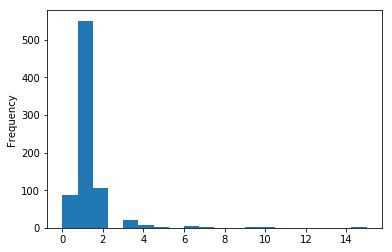

In [24]:
conf.n_funcoes.plot(kind='hist', bins=20)

In [25]:
# mantenho apenas um vínculo por servidor
ufc = ufc.drop_duplicates("nome")

In [26]:
ufc.nlargest(5, "remuneracao_basica_bruta", keep="first")[['remuneracao_basica_bruta', 'nome']]

,remuneracao_basica_bruta,nome
1972,44341.22,LUIZ BOTELHO ALBUQUERQUE
6438,43824.33,SEBASTIAO CARNEIRO DE ALMEIDA
2031,43535.89,HENRY DE HOLANDA CAMPOS
4688,42643.56,CARLOS AUGUSTO ALENCAR JUNIOR
1923,40946.95,BOANERGES FREIRE DE AQUINO


In [22]:
ufc.uorg_lotacao.value_counts().describe()

count    527.000000
mean      11.732448
std       39.898523
min        1.000000
25%        1.000000
50%        3.000000
75%        8.000000
max      734.000000
Name: uorg_lotacao, dtype: float64

In [23]:
ufc.uorg_lotacao.value_counts().loc[lambda x: x < 2].shape

(165,)

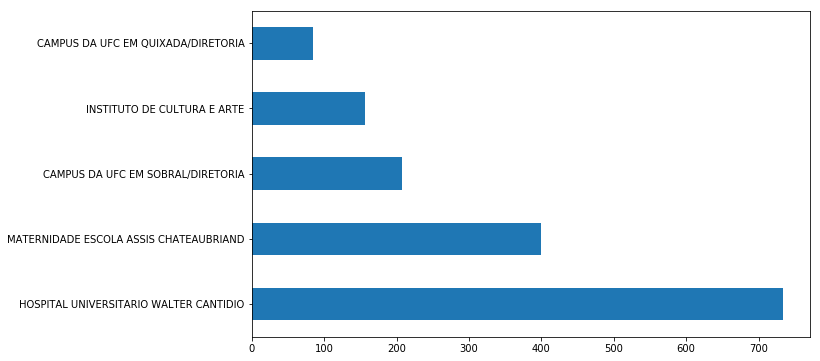

In [24]:
ufc.uorg_lotacao.value_counts().nlargest(5).plot(kind='barh', figsize=(10, 6))

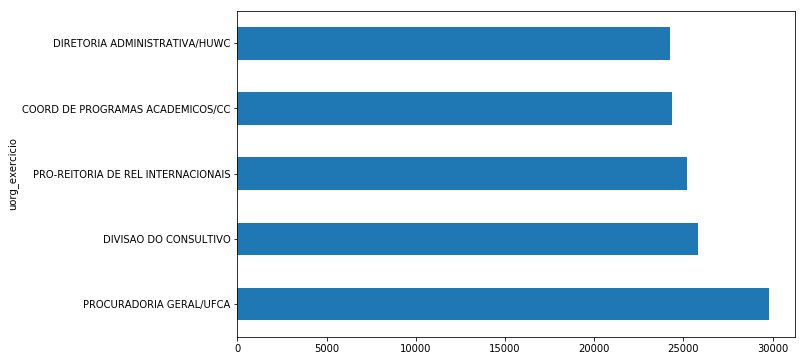

In [25]:
ufc.groupby("uorg_exercicio").remuneracao_basica_bruta.mean().nlargest(5).plot(kind='barh', figsize=(10, 6))

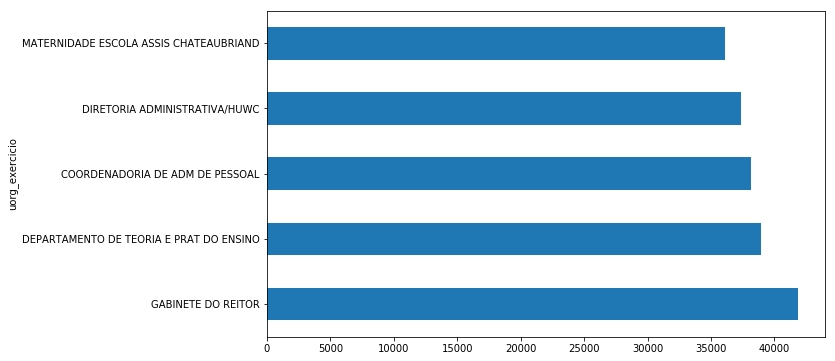

In [26]:
ufc.groupby("uorg_exercicio").remuneracao_basica_bruta.apply(lambda g: g.max() - g.min()).nlargest(5).plot(kind='barh', figsize=(10, 6))

In [27]:
ufc[ufc.uorg_exercicio == 'GABINETE DO REITOR']\
.loc[lambda x: [x.remuneracao_basica_bruta.argmax(), x.remuneracao_basica_bruta.argmin()]]

,cargo,funcao,uorg_lotacao,uorg_exercicio,org_lotacao,org_exercicio,jornada,remuneracao_basica_bruta,remuneracao_pos_deducao,nome
6438,PROFESSOR DO MAGISTERIO SUPERIOR,NaN,NaN,GABINETE DO REITOR,UNIVERSIDADE FEDERAL DO CEARA,UNIVERSIDADE FEDERAL DO CEARA,DEDICACAO EXCLUSIVA,43824.33,30163.89,SEBASTIAO CARNEIRO DE ALMEIDA
7340,LOCUTOR,NaN,GABINETE DO REITOR,GABINETE DO REITOR,UNIVERSIDADE FEDERAL DO CEARA,UNIVERSIDADE FEDERAL DO CEARA,40 HORAS SEMANAIS,1945.07,2010.33,PEDRO VITOR GADELHA MENDES


In [28]:
df = pd.merge(ufc, fcpc, left_on = "nome", right_on = "nome", how = "outer", indicator = True)

In [29]:
df.shape

(131611, 17)

In [30]:
df._merge.value_counts()

right_only    112095
both           14585
left_only       4931
Name: _merge, dtype: int64

In [31]:
fcpcufc = df[df._merge == "both"]

In [32]:
fcpcufc.groupby("nome").valor.sum().nlargest(5)

nome
JAVAM DE CASTRO MACHADO               802283.12
LUIZ ROBERTO DE OLIVEIRA              665245.29
FRANCISCO RODRIGO PORTO CAVALCANTI    606908.99
ROSSANA MARIA DE CASTRO ANDRADE       594043.50
HELANO DE SOUSA CASTRO                579292.22
Name: valor, dtype: float64

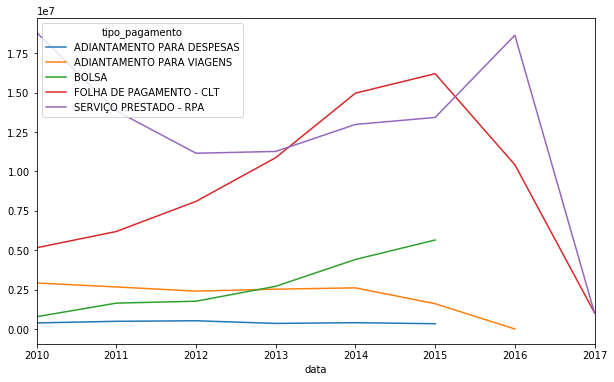

In [33]:
top_5_pagamentos = fcpc.tipo_pagamento.value_counts().nlargest(5)

fcpc[fcpc.tipo_pagamento.isin(top_5_pagamentos.index)].pivot_table("valor", fcpc.data.dt.year, "tipo_pagamento", aggfunc="sum")\
.plot(figsize = (10, 6))

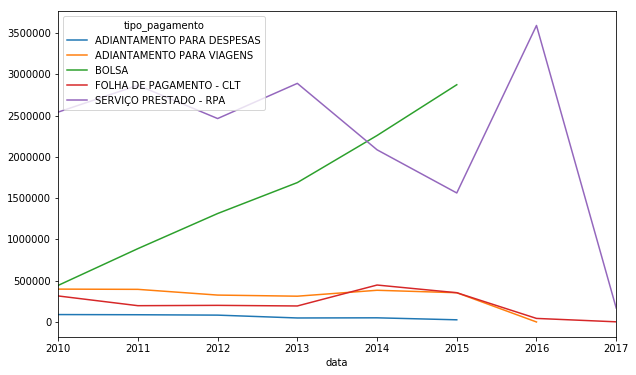

In [34]:
top_5_pagamentos = fcpcufc.tipo_pagamento.value_counts().nlargest(5)

fcpcufc[fcpcufc.tipo_pagamento.isin(top_5_pagamentos.index)].pivot_table("valor", fcpcufc.data.dt.year, "tipo_pagamento", aggfunc="sum")\
.plot(figsize = (10, 6))